In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/raw/clients.csv")


In [2]:
FEATURES = [
    "age",
    "income",
    "credit_amount",
    "loan_duration",
    "employment_years"
]

X = df[FEATURES]
X_norm = (X - X.mean()) / X.std()

df["risk_score"] = (
    0.4 * X_norm["credit_amount"]
    + 0.3 * X_norm["loan_duration"]
    - 0.5 * X_norm["income"]
    - 0.4 * X_norm["employment_years"]
)


In [3]:
EPSILON = 0.10
SENSITIVE_ATTR = "sex"

In [4]:
def acceptance_rate(df, group):
    return df[df[SENSITIVE_ATTR] == group]["accepted"].mean()


In [5]:
best_pair = None
best_acceptance = 0

scores_f = df[df["sex"] == 0]["risk_score"]
scores_m = df[df["sex"] == 1]["risk_score"]

for q_f in np.linspace(0.2, 0.9, 30):
    for q_m in np.linspace(0.2, 0.9, 30):

        t_f = scores_f.quantile(q_f)
        t_m = scores_m.quantile(q_m)

        df["accepted_tmp"] = 0
        df.loc[(df["sex"] == 0) & (df["risk_score"] <= t_f), "accepted_tmp"] = 1
        df.loc[(df["sex"] == 1) & (df["risk_score"] <= t_m), "accepted_tmp"] = 1

        acc_f = df[df["sex"] == 0]["accepted_tmp"].mean()
        acc_m = df[df["sex"] == 1]["accepted_tmp"].mean()

        if abs(acc_f - acc_m) <= EPSILON:
            total_acc = df["accepted_tmp"].mean()
            if total_acc > best_acceptance:
                best_acceptance = total_acc
                best_pair = (t_f, t_m)


In [6]:
t_f, t_m = best_pair

df["accepted_fair"] = 0
df.loc[(df["sex"] == 0) & (df["risk_score"] <= t_f), "accepted_fair"] = 1
df.loc[(df["sex"] == 1) & (df["risk_score"] <= t_m), "accepted_fair"] = 1

df.groupby("sex")["accepted_fair"].mean()


sex
0    0.857143
1    0.875000
Name: accepted_fair, dtype: float64

In [7]:
baseline_acceptance = df.groupby("sex")["accepted"].mean()
fair_acceptance = df.groupby("sex")["accepted_fair"].mean()

baseline_acceptance, fair_acceptance


KeyError: 'Column not found: accepted'

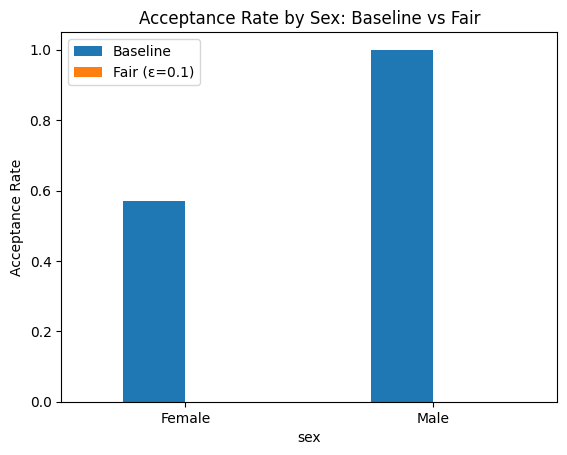

In [9]:
comparison = pd.DataFrame({
    "Baseline": baseline_acceptance,
    "Fair (ε=0.1)": fair_acceptance
})

comparison.plot(kind="bar")
plt.title("Acceptance Rate by Sex: Baseline vs Fair")
plt.ylabel("Acceptance Rate")
plt.xticks([0,1], ["Female", "Male"], rotation=0)
plt.show()
